# 🎓 Student Performance - Pass/Fail Prediction
This notebook trains and evaluates a machine learning model to predict whether a student **passes or fails** based on features like study hours, attendance, parental education, etc.

**Dataset used:** `student_performance_dataset.csv`

In [1]:

# 📦 Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve)
import joblib

# set plotting style
sns.set(style="whitegrid")


In [2]:

# 📂 Load dataset
df = pd.read_csv("student_performance_dataset.csv")
print("Shape:", df.shape)
df.head()


Shape: (300, 10)


,Student_ID,Gender,Age,Study_Hours,Attendance,Parental_Education,Internet_Access,Extracurricular,Test_Score,Performance_Level
0,1,Male,15,3.8,54,Bachelor,Yes,Yes,51.813141,Average
1,2,Female,15,5.8,59,High School,Yes,No,87.032275,Excellent
2,3,Male,17,6.0,82,Bachelor,Yes,Yes,64.750328,Average
3,4,Male,16,1.9,87,Master,Yes,Yes,78.242122,Good
4,5,Male,19,5.4,62,High School,Yes,No,100.000000,Excellent


Target distribution:
Passed
1    280
0     20
Name: count, dtype: int64


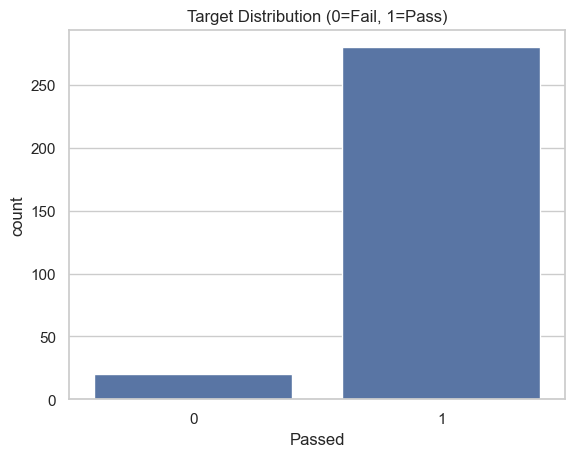

,Student_ID,Gender,Age,Study_Hours,Attendance,Parental_Education,Internet_Access,Extracurricular,Test_Score,Performance_Level,Passed
0,1,Male,15,3.8,54,Bachelor,Yes,Yes,51.813141,Average,1
1,2,Female,15,5.8,59,High School,Yes,No,87.032275,Excellent,1
2,3,Male,17,6.0,82,Bachelor,Yes,Yes,64.750328,Average,1
3,4,Male,16,1.9,87,Master,Yes,Yes,78.242122,Good,1
4,5,Male,19,5.4,62,High School,Yes,No,100.000000,Excellent,1


In [3]:

# 🎯 Create target variable: Passed (1 if Test_Score >= 50 else 0)
df["Passed"] = (df["Test_Score"] >= 50).astype(int)

print("Target distribution:")
print(df["Passed"].value_counts())
sns.countplot(x="Passed", data=df)
plt.title("Target Distribution (0=Fail, 1=Pass)")
plt.show()

df.head()


In [4]:

# 🔎 Select features (excluding Test_Score to avoid leakage)
features = ["Gender", "Age", "Study_Hours", "Attendance",
            "Parental_Education", "Internet_Access", "Extracurricular"]

X = df[features].copy()
y = df["Passed"].copy()


In [5]:

# ⚙️ Preprocessing pipelines
numeric_features = ["Age", "Study_Hours", "Attendance"]
categorical_features = ["Gender", "Parental_Education", "Internet_Access", "Extracurricular"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


In [6]:

# ✂️ Train/test split (80/20 with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train size:", X_train.shape, " Test size:", X_test.shape)


Train size: (240, 7)  Test size: (60, 7)


In [7]:

# 🤖 Build models
pipeline_lr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

pipeline_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=150, random_state=42))
])


In [8]:

# 🏋️ Train both models
pipeline_lr.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [9]:

# 📊 Evaluation function
def evaluate_model(pipe, X_t, y_t, name="model"):
    preds = pipe.predict(X_t)
    probs = pipe.predict_proba(X_t)[:,1] if hasattr(pipe, "predict_proba") else None
    
    acc = accuracy_score(y_t, preds)
    prec = precision_score(y_t, preds, zero_division=0)
    rec = recall_score(y_t, preds, zero_division=0)
    f1 = f1_score(y_t, preds, zero_division=0)
    auc = roc_auc_score(y_t, probs) if probs is not None else None
    
    print(f"=== {name} ===")
    print("Accuracy:", round(acc,4))
    print("Precision:", round(prec,4))
    print("Recall:", round(rec,4))
    print("F1-score:", round(f1,4))
    if auc: print("ROC AUC:", round(auc,4))
    print("\nClassification Report:\n", classification_report(y_t, preds, zero_division=0))
    
    cm = confusion_matrix(y_t, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    if probs is not None:
        # ROC
        fpr, tpr, _ = roc_curve(y_t, probs)
        plt.plot(fpr, tpr, label="ROC")
        plt.plot([0,1],[0,1],"--", color="grey")
        plt.title(f"ROC Curve: {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show()
        
        # Precision-Recall
        precision, recall, _ = precision_recall_curve(y_t, probs)
        plt.plot(recall, precision, label="PR")
        plt.title(f"Precision-Recall Curve: {name}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.show()


=== Logistic Regression ===
Accuracy: 0.9333
Precision: 0.9333
Recall: 1.0
F1-score: 0.9655
ROC AUC: 0.6295

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.93      1.00      0.97        56

    accuracy                           0.93        60
   macro avg       0.47      0.50      0.48        60
weighted avg       0.87      0.93      0.90        60



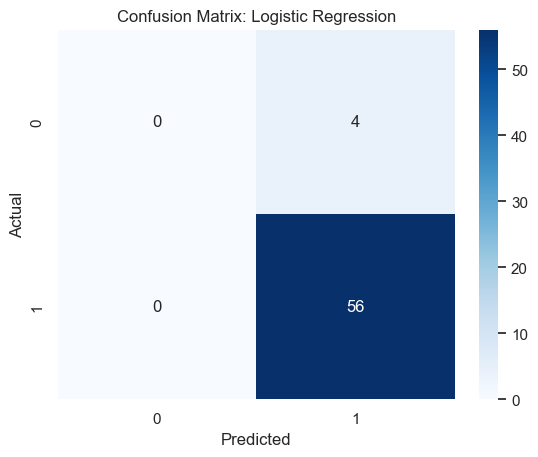

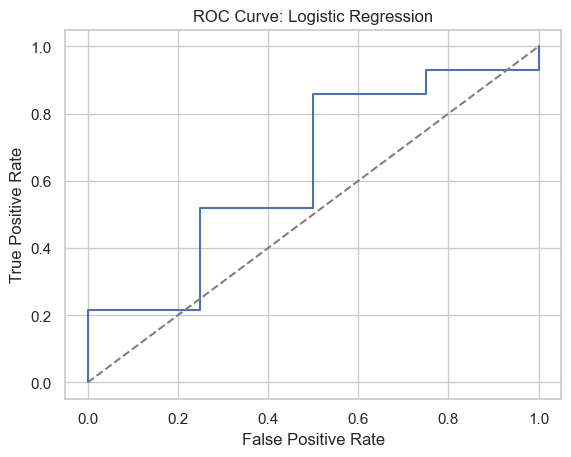

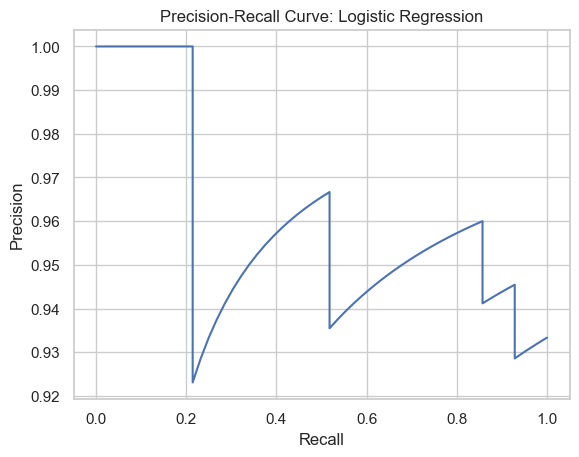

=== Random Forest ===
Accuracy: 0.9167
Precision: 0.9322
Recall: 0.9821
F1-score: 0.9565
ROC AUC: 0.4621

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.93      0.98      0.96        56

    accuracy                           0.92        60
   macro avg       0.47      0.49      0.48        60
weighted avg       0.87      0.92      0.89        60



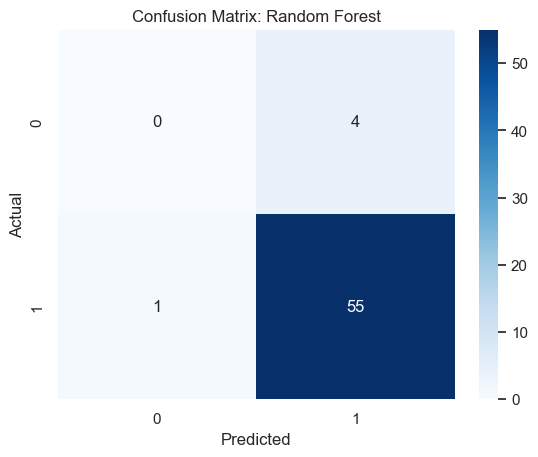

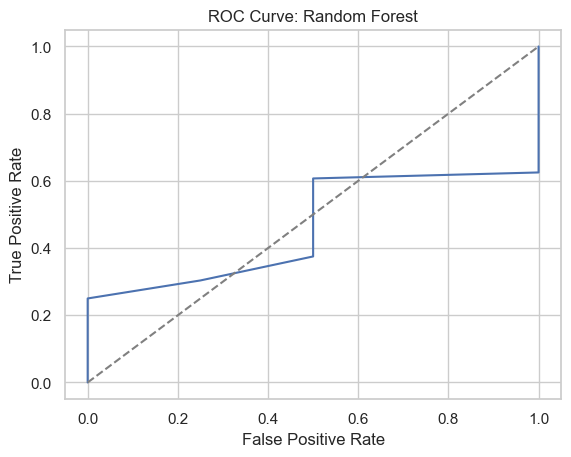

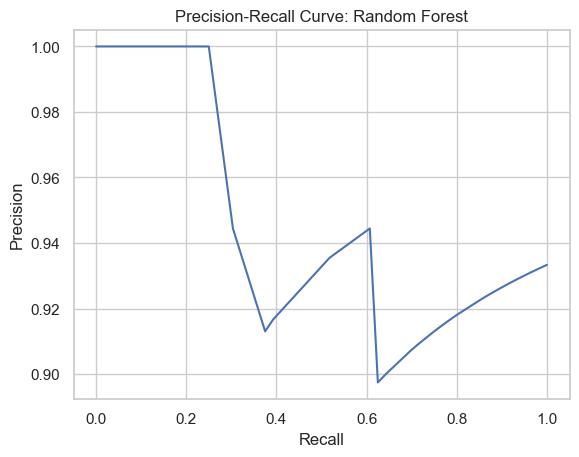

In [10]:

# 🔍 Evaluate both models
evaluate_model(pipeline_lr, X_test, y_test, name="Logistic Regression")
evaluate_model(pipeline_rf, X_test, y_test, name="Random Forest")


In [11]:

# 💾 Save best model (Random Forest selected here for demo)
best_model = pipeline_rf
joblib.dump(best_model, "pass_fail_model.pkl")
print("Model saved to pass_fail_model.pkl")


Model saved to pass_fail_model.pkl


In [12]:

# 🧪 Try predicting a new student
new_student = pd.DataFrame([{
    "Gender": "Male",
    "Age": 17,
    "Study_Hours": 4.5,
    "Attendance": 80,
    "Parental_Education": "High School",
    "Internet_Access": "Yes",
    "Extracurricular": "No"
}])

pred = best_model.predict(new_student)
prob = best_model.predict_proba(new_student)[:,1]
print("Prediction (1=Pass, 0=Fail):", pred[0], " Probability of passing:", round(prob[0],3))


Prediction (1=Pass, 0=Fail): 1  Probability of passing: 0.913
